# Creating the dataset in another format

In [1]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
import copy
import sys

from scipy import stats
from numba import njit

In [2]:
sys.path.append('../')

from src import load_data

## Loading root file and preprocessing the data

- We load the root file using uproot and show its contents. We can then obtain a dictionary where keys are some of the TTree names and values are numpy arrays containing the data. **Note that we only keep a subset of the information**.

In [3]:
data_dict = load_data.load_data_as_dict(TTree_features_dict={
                        "t_hk_obox":
                                ["saa", 
                               "raz",
                               "decz",
                               "rax",
                               "decx",
                               "obox_mode",
                               "fe_temp",
                               "glon", 
                               "glat",
                               "tunix",
                               "fe_cosmic",
                               "fe_rate"],
                        "B_field":
                                ["B_r",
                                 "B_theta",
                                 "B_phi"]
                        })

TTree: t_hk_obox's contents:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
odd_index            | int32_t                  | AsDtype('>i4')
even_index           | int32_t                  | AsDtype('>i4')
odd_is_bad           | int32_t                  | AsDtype('>i4')
even_is_bad          | int32_t                  | AsDtype('>i4')
obox_is_bad          | int32_t                  | AsDtype('>i4')
packet_num           | uint16_t                 | AsDtype('>u2')
timestamp            | uint32_t                 | AsDtype('>u4')
obox_mode            | uint8_t                  | AsDtype('uint8')
cpu_status           | uint16_t                 | AsDtype('>u2')
trig_status          | uint8_t                  | AsDtype('uint8')
comm_status          | uint8_t                  | AsDtype('uint8')
ct_temp              | float                    | AsDtype('>f4')
chain_temp           | 

The TTree `B_field` contains information on the magnetic field and is aligned with the data in `t_hk_obox`

In [4]:
data_dict.keys()

dict_keys(['saa', 'raz', 'decz', 'rax', 'decx', 'obox_mode', 'fe_temp', 'glon', 'glat', 'tunix', 'fe_cosmic', 'fe_rate', 'B_r', 'B_theta', 'B_phi'])

- Create a pandas dataframe containing all the features we selected where `fe_temp`, `fe_cosmic` and `fe_rate` are summed up over the modules (sum of $25$ modules).

In [5]:
def try_sum_axis_1(el):
    try:
        return np.sum(el, axis=1)
    except:
        return el


In [6]:
data_df = pd.DataFrame.from_dict({"sum_"*(k in ["fe_cosmic", "fe_temp", "fe_rate"])+k: try_sum_axis_1(v)
                                 for k, v in data_dict.items()})
data_df

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
0,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-176.248994,-18.145817,1.473950e+09,0,0,22978.488024,-27875.425937,6282.740022
1,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-176.148294,-18.231030,1.473950e+09,0,0,23045.553463,-27845.821903,6289.577967
2,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-176.047467,-18.316198,1.473950e+09,0,0,23112.394223,-27816.130122,6296.418849
3,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-175.845556,-18.486292,1.473950e+09,0,0,23245.311806,-27756.526414,6310.101138
4,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-175.744447,-18.571237,1.473950e+09,0,0,23311.402886,-27726.609781,6316.944439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6210970,2,268.013883,-31.620136,275.484638,58.161383,4,0.0,171.225550,-42.585450,1.502787e+09,0,0,44109.780558,-16055.052240,6686.401683
6210971,2,268.163352,-31.627999,275.427072,58.165486,4,0.0,171.392950,-42.595320,1.502787e+09,0,0,44078.264948,-16059.079066,6700.485328
6210972,2,268.312347,-31.635979,275.369218,58.169123,4,0.0,171.560500,-42.604890,1.502787e+09,0,0,44046.393963,-16063.233767,6714.466567
6210973,2,268.461162,-31.644019,275.311241,58.172357,4,0.0,171.728050,-42.614190,1.502787e+09,0,0,44014.515542,-16067.598163,6728.385629


In [7]:
data_df.dtypes

saa               uint16
raz              float64
decz             float64
rax              float64
decx             float64
obox_mode          uint8
sum_fe_temp      float32
glon             float64
glat             float64
tunix            float64
sum_fe_cosmic     uint32
sum_fe_rate       uint32
B_r              float64
B_theta          float64
B_phi            float64
dtype: object

**Need for normalizing some features ? Probably, we'll do it later and after splitting the data (otherwise data leakage)!!**

- Filter out the data and bin the data

We first remove a huge part of missing data

In [8]:
last_non_zero = data_df.shape[0]-(np.flip(data_df["sum_fe_rate"])>0).argmax() - 1

In [9]:
data_df = data_df.iloc[:last_non_zero+1, :]
data_df

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
0,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-176.248994,-18.145817,1.473950e+09,0,0,22978.488024,-27875.425937,6282.740022
1,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-176.148294,-18.231030,1.473950e+09,0,0,23045.553463,-27845.821903,6289.577967
2,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-176.047467,-18.316198,1.473950e+09,0,0,23112.394223,-27816.130122,6296.418849
3,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-175.845556,-18.486292,1.473950e+09,0,0,23245.311806,-27756.526414,6310.101138
4,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-175.744447,-18.571237,1.473950e+09,0,0,23311.402886,-27726.609781,6316.944439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187662,0,274.174833,-4.945285,260.499167,84.911170,4,0.0,43.835300,-15.995880,1.491273e+09,0,0,20797.564440,-18662.786449,-3486.045002
6187663,0,274.276958,-5.029454,260.767636,84.828197,4,0.0,43.930200,-16.080150,1.491273e+09,0,0,20848.026922,-18635.681413,-3515.989772
6187664,0,274.379394,-5.113467,261.032234,84.745364,4,0.0,44.025250,-16.164390,1.491273e+09,0,0,20898.528499,-18608.662998,-3545.976294
6187665,0,274.481898,-5.197639,261.290657,84.662301,4,0.0,44.120350,-16.248570,1.491273e+09,0,0,20949.138349,-18581.787518,-3575.998276


Then we "bin" the data (like profile hist but without error bars and without plotting)

In [10]:
tunix_min = data_df["tunix"].min()
tunix_shifted = data_df["tunix"] - tunix_min
bins = np.arange(0, tunix_shifted.max()+2, 2)

# Obtain indices of the bins in which the data falls.
# It will take the bin on the right, not the one of the left
indices_digitized = np.digitize(tunix_shifted, bins)

# Quantized Shifted Time
t = bins[indices_digitized]

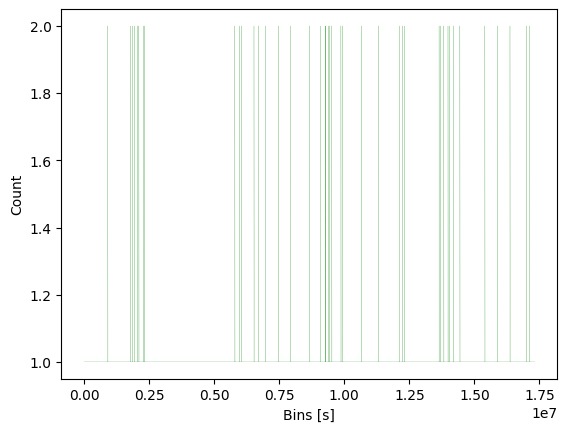

In [11]:
uniques_idx, counts_idx = np.unique(indices_digitized, return_counts=True)
plt.plot(bins[uniques_idx], counts_idx, 'g', linewidth=0.1)
plt.xlabel("Bins [s]")
plt.ylabel("Count")  # nb. data falling into bin
plt.show()

In [12]:
np.unique(bins[uniques_idx]).size, bins.size

(6187623, 8661519)

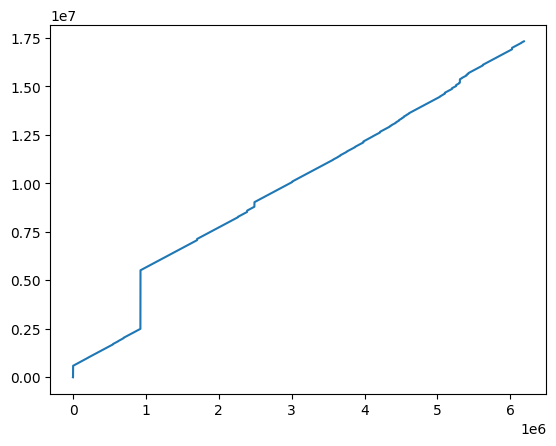

In [13]:
plt.plot(np.unique(bins[uniques_idx]))

Note: There are **empty bins**, need to be careful with them !!

In [14]:
data_df.loc[:, ("idx")] = indices_digitized

C:\Users\steph\AppData\Local\Temp\ipykernel_26740\3418129158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[:, ("idx")] = indices_digitized


In [15]:
data_df

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi,idx
0,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-176.248994,-18.145817,1.473950e+09,0,0,22978.488024,-27875.425937,6282.740022,1
1,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-176.148294,-18.231030,1.473950e+09,0,0,23045.553463,-27845.821903,6289.577967,2
2,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-176.047467,-18.316198,1.473950e+09,0,0,23112.394223,-27816.130122,6296.418849,3
3,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-175.845556,-18.486292,1.473950e+09,0,0,23245.311806,-27756.526414,6310.101138,5
4,2,120.610330,-29.618949,92.824979,57.274821,1,0.0,-175.744447,-18.571237,1.473950e+09,0,0,23311.402886,-27726.609781,6316.944439,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187662,0,274.174833,-4.945285,260.499167,84.911170,4,0.0,43.835300,-15.995880,1.491273e+09,0,0,20797.564440,-18662.786449,-3486.045002,8661514
6187663,0,274.276958,-5.029454,260.767636,84.828197,4,0.0,43.930200,-16.080150,1.491273e+09,0,0,20848.026922,-18635.681413,-3515.989772,8661515
6187664,0,274.379394,-5.113467,261.032234,84.745364,4,0.0,44.025250,-16.164390,1.491273e+09,0,0,20898.528499,-18608.662998,-3545.976294,8661516
6187665,0,274.481898,-5.197639,261.290657,84.662301,4,0.0,44.120350,-16.248570,1.491273e+09,0,0,20949.138349,-18581.787518,-3575.998276,8661517


In [16]:
data_df = data_df.groupby("idx").mean()

In [17]:
data_df

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
idx,,,,,,,,,,,,,,,
1,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.248994,-18.145817,1.473950e+09,0.0,0.0,22978.488024,-27875.425937,6282.740022
2,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.148294,-18.231030,1.473950e+09,0.0,0.0,23045.553463,-27845.821903,6289.577967
3,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-176.047467,-18.316198,1.473950e+09,0.0,0.0,23112.394223,-27816.130122,6296.418849
5,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.845556,-18.486292,1.473950e+09,0.0,0.0,23245.311806,-27756.526414,6310.101138
6,2.0,120.610330,-29.618949,92.824979,57.274821,1.0,0.0,-175.744447,-18.571237,1.473950e+09,0.0,0.0,23311.402886,-27726.609781,6316.944439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8661514,0.0,274.174833,-4.945285,260.499167,84.911170,4.0,0.0,43.835300,-15.995880,1.491273e+09,0.0,0.0,20797.564440,-18662.786449,-3486.045002
8661515,0.0,274.276958,-5.029454,260.767636,84.828197,4.0,0.0,43.930200,-16.080150,1.491273e+09,0.0,0.0,20848.026922,-18635.681413,-3515.989772
8661516,0.0,274.379394,-5.113467,261.032234,84.745364,4.0,0.0,44.025250,-16.164390,1.491273e+09,0.0,0.0,20898.528499,-18608.662998,-3545.976294


In [18]:
data_df.dtypes  # everything changed to float64 due to .mean()

saa              float64
raz              float64
decz             float64
rax              float64
decx             float64
obox_mode        float64
sum_fe_temp      float32
glon             float64
glat             float64
tunix            float64
sum_fe_cosmic    float64
sum_fe_rate      float64
B_r              float64
B_theta          float64
B_phi            float64
dtype: object

In [19]:
data_df.describe()

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
count,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06,6.187623e+06
mean,7.038711e-01,1.808892e+02,4.831418e+00,1.964191e+02,2.546177e+01,2.748524e+00,7.988566e+02,-9.676484e-03,-1.350034e-02,1.483772e+09,5.208050e+03,1.246811e+04,4.904592e+02,-2.134118e+04,4.953057e+00
std,9.327070e-01,1.046748e+02,3.040098e+01,1.085227e+02,4.010342e+01,1.948635e+00,9.936823e+01,1.039543e+02,2.948083e+01,4.697624e+06,5.036375e+03,1.139591e+04,2.622744e+04,5.805424e+03,4.173055e+03
min,0.000000e+00,6.601582e-06,-5.203507e+01,8.365495e-05,-8.996060e+01,1.000000e+00,-5.312500e+01,-1.800000e+02,-4.285662e+01,1.473950e+09,0.000000e+00,0.000000e+00,-4.251755e+04,-3.435962e+04,-1.045340e+04
25%,0.000000e+00,8.999910e+01,-2.348037e+01,9.099418e+01,1.356290e+01,2.000000e+00,7.406250e+02,-9.005848e+01,-2.871740e+01,1.480710e+09,2.710000e+03,7.617000e+03,-2.523661e+04,-2.518458e+04,-3.279673e+03
50%,0.000000e+00,1.809293e+02,3.849592e+00,2.236406e+02,3.926563e+01,2.000000e+00,8.083333e+02,-6.605000e-02,-1.848000e-02,1.484214e+09,3.715000e+03,1.040200e+04,2.905587e+03,-2.167025e+04,-9.138861e-01
75%,2.000000e+00,2.727324e+02,3.312104e+01,2.888757e+02,5.153704e+01,2.000000e+00,8.635417e+02,9.011735e+01,2.868264e+01,1.487626e+09,6.715000e+03,1.565800e+04,2.061145e+04,-1.779998e+04,3.600060e+03
max,2.000000e+00,3.600000e+02,5.380582e+01,3.599999e+02,8.995123e+01,8.000000e+00,9.979167e+02,1.800000e+02,4.285662e+01,1.491273e+09,1.056040e+05,2.269590e+05,5.075649e+04,-8.598409e+03,8.130635e+03


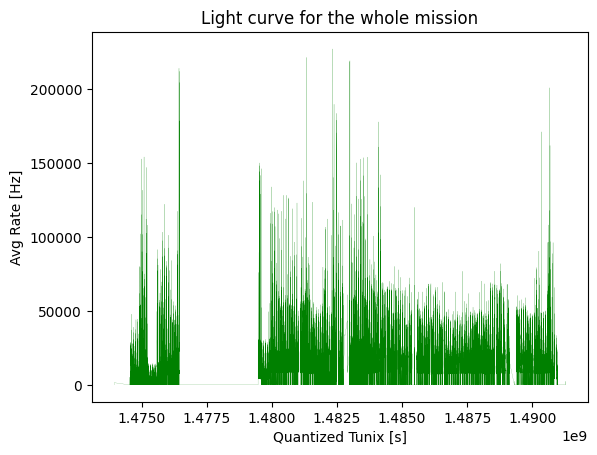

In [20]:
plt.plot(data_df['tunix'], data_df['sum_fe_rate'], 'g', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

Note: We need to be careful about the empty bins, so it's not really equidistant times between each example. We won't be able to use FFT

In [21]:
# Uncomment below if want to export the data into a CSV file
# import os  

# os.makedirs('../data', exist_ok=True)
# data_df.to_csv('../data/polar_dataset_binned.csv', index=False)  

It's easier for us to, for the moment, remove what happens before and during the moment astronauts went onboard the space station (before and during the huge middle part with missing data).

924648 5.0


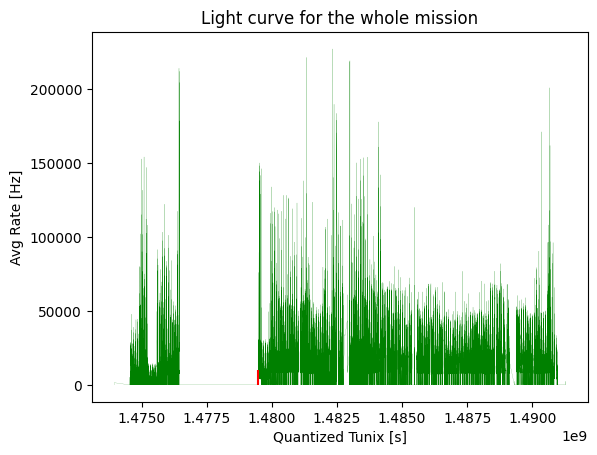

In [22]:
# Find idx
idx_right = np.argmax((data_df['tunix'] > 1.4775*1e9) & (data_df['sum_fe_rate'] > 0))
print(idx_right, data_df['sum_fe_rate'].iloc[idx_right])

# Let's visualize to see if correct idx
plt.plot(data_df['tunix'], data_df['sum_fe_rate'], 'g', linewidth=0.1)
plt.vlines(data_df['tunix'].iloc[idx_right], 0, 10_000, 'r')
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

In [23]:
data_df = data_df.iloc[idx_right:data_df.shape[0], :]

In [24]:
import os  

os.makedirs('../data', exist_ok=True)
data_df.to_csv('../data/polar_dataset.csv', index=False)  

In [25]:
corr = data_df.corr()

In [26]:
corr

,saa,raz,decz,rax,decx,obox_mode,sum_fe_temp,glon,glat,tunix,sum_fe_cosmic,sum_fe_rate,B_r,B_theta,B_phi
saa,1.000000,0.008131,0.019461,-0.146167,-0.128785,-0.142659,-0.184700,0.002887,0.047496,-0.076861,0.058351,0.041201,-0.005760,-0.057570,0.042619
raz,0.008131,1.000000,0.083527,-0.114804,0.190301,-0.006030,-0.164876,-0.017019,0.026996,-0.029898,-0.012645,0.006483,-0.026997,-0.019561,-0.001825
decz,0.019461,0.083527,1.000000,-0.096701,0.083359,-0.337315,-0.005575,-0.006812,0.952733,-0.016209,-0.025139,-0.006533,-0.906323,-0.425191,-0.006280
rax,-0.146167,-0.114804,-0.096701,1.000000,0.195639,0.030754,0.172211,0.001744,-0.138125,-0.229382,0.054844,0.050510,0.132297,0.067000,0.010851
decx,-0.128785,0.190301,0.083359,0.195639,1.000000,0.059696,0.036561,-0.006216,-0.161624,-0.010165,0.043913,0.054292,0.150984,0.095078,0.000073
obox_mode,-0.142659,-0.006030,-0.337315,0.030754,0.059696,1.000000,-0.020455,-0.108804,-0.354177,0.004112,-0.381835,-0.414227,0.189356,0.468773,-0.271070
sum_fe_temp,-0.184700,-0.164876,-0.005575,0.172211,0.036561,-0.020455,1.000000,0.001774,-0.024944,0.095260,0.127505,0.112883,0.026669,0.005235,0.011424
glon,0.002887,-0.017019,-0.006812,0.001744,-0.006216,-0.108804,0.001774,1.000000,-0.002236,-0.000338,0.088133,0.079806,0.156317,-0.198840,-0.296584
glat,0.047496,0.026996,0.952733,-0.138125,-0.161624,-0.354177,-0.024944,-0.002236,1.000000,-0.000559,-0.048113,-0.032696,-0.948355,-0.463218,-0.004082
tunix,-0.076861,-0.029898,-0.016209,-0.229382,-0.010165,0.004112,0.095260,-0.000338,-0.000559,1.000000,-0.058350,-0.073236,0.000730,-0.002749,0.004364


Text(0.5, 1.0, 'Correlation Matrix between types of measurements')

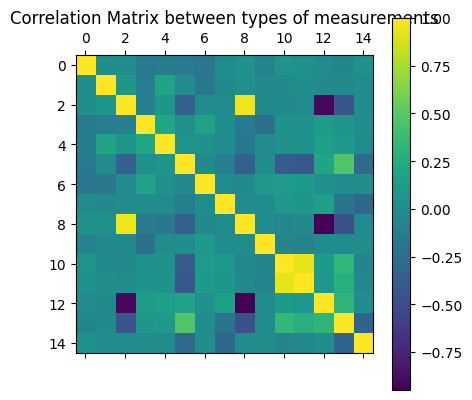

In [27]:
plt.matshow(corr)
plt.colorbar()

plt.title('Correlation Matrix between types of measurements')

In [28]:
corr["sum_fe_rate"]

saa              0.041201
raz              0.006483
decz            -0.006533
rax              0.050510
decx             0.054292
obox_mode       -0.414227
sum_fe_temp      0.112883
glon             0.079806
glat            -0.032696
tunix           -0.073236
sum_fe_cosmic    0.926909
sum_fe_rate      1.000000
B_r              0.087670
B_theta          0.278132
B_phi           -0.039451
Name: sum_fe_rate, dtype: float64

## (Optional) Filter out data when astronauts onboard space station or when `obox_mode` has certain values

If we filter out data in a non-contiguous way from either the begining of the light curve or from the end, we wouldn't be able to apply FFT. This would require something else, maybe **non-uniform DFT** (to learn what it is and how to interprete it)

- We need to filter even more by removing the huge middle part with missing data when the astronauts went onboard the space station.

In [ ]:
# Find range
idx_left = data_df.shape[0] - np.argmax((np.flip(data_df['tunix']) < 1.4775*1e9)\
                     & (np.flip(data_df['sum_fe_rate']) > 0)) - 1
idx_right = np.argmax((data_df['tunix'] > 1.4775*1e9) & (data_df['sum_fe_rate'] > 0))
print(idx_left, data_df['sum_fe_rate'].iloc[idx_left], idx_right, data_df['sum_fe_rate'].iloc[idx_right])

# Let's visualize to see if correct idx
plt.plot(data_df['tunix'], data_df['sum_fe_rate'], 'g', linewidth=0.1)
plt.vlines(data_df['tunix'].iloc[idx_left], 0, 10_000, 'r')
plt.vlines(data_df['tunix'].iloc[idx_right], 0, 10_000, 'r')
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

It also showed that there are data that we're not interested in within this period. Let's delete them from our dataframe, it shouldn't impact the light curve.
**However, data are not at equidistant time** (even though it already wasn't due to missing data)

In [ ]:
data_df = data_df.iloc[np.concatenate([np.arange(idx_left+1), np.arange(idx_right, data_df.shape[0])]), :]

In [ ]:
data_df

- We also need to take care of `obox_mode`

In [ ]:
plt.plot(data_df['obox_mode'], data_df['sum_fe_rate'], '.')
plt.show()